In [1]:
import math
import os
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy import optimize
from scipy.spatial import distance_matrix
from d2l import torch as d2l

d2l.set_figsize()

# 18.1. Introduction to Gaussian Processes

- Kernel (covariance function), controls properties of the Gaussian process that we used to fit the data
    - one example is RBF (Radial Basis Function) kernel, $k_{\textrm{RBF}}(x,x') = \textrm{Cov}(f(x),f(x')) = a^2 \exp\left(-\frac{1}{2\ell^2}||x-x'||^2\right)$
        -  The amplitude parameter $a$ controls the vertical scale over which the function is varying. Larger $a$ means larger function values, 
        - and the length-scale parameter $\ell$ controls the rate of variation (the wiggliness) of the function.Larger $\ell$ means more slowly varying functions
        - A Gaussian process with an RBF kernel is a universal approximator, capable of representing any continuous function to arbitrary precision
        - Gaussian process with an RBF kernel is a model with an infinite number of parameters and much more flexibility than any finite neural network and it does not overfit
        - stationary, means that the high-level properties of the function, such as rate of variation, do not change as we move in input space
- GP prior
$$\begin{split}\begin{bmatrix}f(x) \\f(x_1) \\ \vdots \\ f(x_n) \end{bmatrix}\sim \mathcal{N}\left(\mu, \begin{bmatrix}k(x,x) & k(x, x_1) & \dots & k(x,x_n) \\ k(x_1,x) & k(x_1,x_1) & \dots & k(x_1,x_n) \\ \vdots & \vdots & \ddots & \vdots \\ k(x_n, x) & k(x_n, x_1) & \dots & k(x_n,x_n) \end{bmatrix}\right)\end{split}$$
- GP posterior
$$f(x) | f(x_1), \dots, f(x_n) \sim \mathcal{N}(m,s^2)$$
where
$$m = k(x,x_{1:n}) k(x_{1:n},x_{1:n})^{-1} f(x_{1:n})$$
$$s^2 = k(x,x) - k(x,x_{1:n})k(x_{1:n},x_{1:n})^{-1}k(x,x_{1:n})$$

# 18.2. Gaussian Process Priors

- $f(x)$ is a random function, or a distribution over functions.  
eg.   
Suppose $f(x) = w_0 + w_1 x$, and $w_0, w_1 \sim \mathcal{N}(0,1)$, with $w_0, w_1, x$ all in one dimension$$f(x) = (w_0, w_1)(1, x)^{\top}$$
For any $x$, $f(x)$ is a sum of two Gaussian random variables. Since Gaussians are closed under addition, $f(x)$ is also a Gaussian random variable for any $x$.


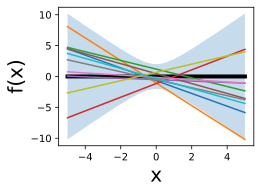

In [3]:
def lin_func(x, n_sample):
    preds = np.zeros((n_sample, x.shape[0]))
    for ii in range(n_sample):
        w = np.random.normal(0, 1, 2)
        y = w[0] + w[1] * x
        preds[ii, :] = y
    return preds


x_points = np.linspace(-5, 5, 50)
outs = lin_func(x_points, 10)
lw_bd = -2 * np.sqrt((1 + x_points**2))
up_bd = 2 * np.sqrt((1 + x_points**2))

d2l.plt.fill_between(x_points, lw_bd, up_bd, alpha=0.25)
d2l.plt.plot(x_points, np.zeros(len(x_points)), linewidth=4, color="black")
d2l.plt.plot(x_points, outs.T)
d2l.plt.xlabel("x", fontsize=20)
d2l.plt.ylabel("f(x)", fontsize=20)
d2l.plt.show()

## 18.2.4. The Radial Basis Function (RBF) Kernel

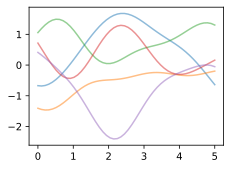

In [4]:
def rbfkernel(x1, x2, ls=4.0):  # @save
    dist = distance_matrix(np.expand_dims(x1, 1), np.expand_dims(x2, 1))
    return np.exp(-(1.0 / ls / 2) * (dist**2))


x_points = np.linspace(0, 5, 50)
meanvec = np.zeros(len(x_points))
covmat = rbfkernel(x_points, x_points, 1)

prior_samples = np.random.multivariate_normal(meanvec, covmat, size=5)
d2l.plt.plot(x_points, prior_samples.T, alpha=0.5)
d2l.plt.show()

# 18.3. Gaussian Process Inference

- log marginal likelihood
$$\log p(\textbf{y} | \theta, X) = -\frac{1}{2}\textbf{y}^{\top}[K_{\theta}(X,X) + \sigma^2I]^{-1}\textbf{y} - \frac{1}{2}\log|K_{\theta}(X,X)| + c$$
- predictive distribution
$$p(y_* | x_*, \textbf{y}, \theta) = \mathcal{N}(a_*,v_*)$$
$$a_* = k_{\theta}(x_*,X)[K_{\theta}(X,X)+\sigma^2I]^{-1}(\textbf{y}-\mu) + \mu$$
$$v_* = k_{\theta}(x_*,x_*) - K_{\theta}(x_*,X)[K_{\theta}(X,X)+\sigma^2I]^{-1}k_{\theta}(X,x_*)$$

## 18.3.4. Worked Example from Scratch

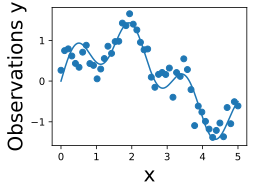

In [2]:
def data_maker1(x, sig):
    return np.sin(x) + 0.5 * np.sin(4 * x) + np.random.randn(x.shape[0]) * sig


sig = 0.25
train_x, test_x = np.linspace(0, 5, 50), np.linspace(0, 5, 500)
train_y, test_y = data_maker1(train_x, sig=sig), data_maker1(test_x, sig=0.0)

d2l.plt.scatter(train_x, train_y)
d2l.plt.plot(test_x, test_y)
d2l.plt.xlabel("x", fontsize=20)
d2l.plt.ylabel("Observations y", fontsize=20)
d2l.plt.show()

In [3]:
mean = np.zeros(test_x.shape[0])
cov = d2l.rbfkernel(test_x, test_x, ls=0.2)

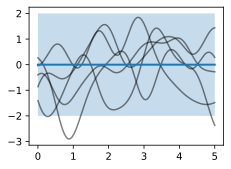

In [4]:
prior_samples = np.random.multivariate_normal(mean=mean, cov=cov, size=5)
d2l.plt.plot(test_x, prior_samples.T, color="black", alpha=0.5)
d2l.plt.plot(test_x, mean, linewidth=2.0)
d2l.plt.fill_between(
    test_x, mean - 2 * np.diag(cov), mean + 2 * np.diag(cov), alpha=0.25
)
d2l.plt.show()

In [5]:
ell_est = 0.4
post_sig_est = 0.5


def neg_MLL(pars):
    K = d2l.rbfkernel(train_x, train_x, ls=pars[0])
    kernel_term = (
        -0.5
        * train_y
        @ np.linalg.inv(K + pars[1] ** 2 * np.eye(train_x.shape[0]))
        @ train_y
    )
    logdet = -0.5 * np.log(np.linalg.det(K + pars[1] ** 2 * np.eye(train_x.shape[0])))
    const = -train_x.shape[0] / 2.0 * np.log(2 * np.pi)

    return -(kernel_term + logdet + const)


learned_hypers = optimize.minimize(
    neg_MLL, x0=np.array([ell_est, post_sig_est]), bounds=((0.01, 10.0), (0.01, 10.0))
)
ell = learned_hypers.x[0]
post_sig_est = learned_hypers.x[1]

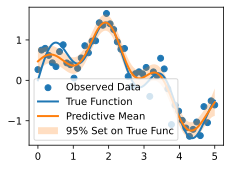

In [6]:
K_x_xstar = d2l.rbfkernel(train_x, test_x, ls=ell)
K_x_x = d2l.rbfkernel(train_x, train_x, ls=ell)
K_xstar_xstar = d2l.rbfkernel(test_x, test_x, ls=ell)

post_mean = (
    K_x_xstar.T
    @ np.linalg.inv((K_x_x + post_sig_est**2 * np.eye(train_x.shape[0])))
    @ train_y
)
post_cov = (
    K_xstar_xstar
    - K_x_xstar.T
    @ np.linalg.inv((K_x_x + post_sig_est**2 * np.eye(train_x.shape[0])))
    @ K_x_xstar
)

lw_bd = post_mean - 2 * np.sqrt(np.diag(post_cov))
up_bd = post_mean + 2 * np.sqrt(np.diag(post_cov))

d2l.plt.scatter(train_x, train_y)
d2l.plt.plot(test_x, test_y, linewidth=2.0)
d2l.plt.plot(test_x, post_mean, linewidth=2.0)
d2l.plt.fill_between(test_x, lw_bd, up_bd, alpha=0.25)
d2l.plt.legend(
    ["Observed Data", "True Function", "Predictive Mean", "95% Set on True Func"]
)
d2l.plt.show()

In [7]:
lw_bd_observed = post_mean - 2 * np.sqrt(np.diag(post_cov) + post_sig_est**2)
up_bd_observed = post_mean + 2 * np.sqrt(np.diag(post_cov) + post_sig_est**2)

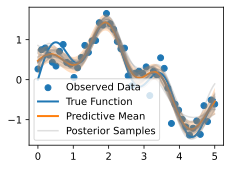

In [8]:
post_samples = np.random.multivariate_normal(post_mean, post_cov, size=20)
d2l.plt.scatter(train_x, train_y)
d2l.plt.plot(test_x, test_y, linewidth=2.0)
d2l.plt.plot(test_x, post_mean, linewidth=2.0)
d2l.plt.plot(test_x, post_samples.T, color="gray", alpha=0.25)
d2l.plt.fill_between(test_x, lw_bd, up_bd, alpha=0.25)
plt.legend(["Observed Data", "True Function", "Predictive Mean", "Posterior Samples"])
d2l.plt.show()

## 18.3.5. Making Life Easy with GPyTorch

In [9]:
# First let's convert our data into tensors for use with PyTorch
train_x = torch.tensor(train_x)
train_y = torch.tensor(train_y)
test_y = torch.tensor(test_y)


# We are using exact GP inference with a zero mean and RBF kernel
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [10]:
# Initialize Gaussian likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)
training_iter = 50
# Find optimal model hyperparameters
model.train()
likelihood.train()
# Use the adam optimizer, includes GaussianLikelihood parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
# Set our loss as the negative log GP marginal likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [11]:
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    if i % 10 == 0:
        print(
            f"Iter {i+1:d}/{training_iter:d} - Loss: {loss.item():.3f} "
            f"squared lengthscale: "
            f"{model.covar_module.base_kernel.lengthscale.item():.3f} "
            f"noise variance: {model.likelihood.noise.item():.3f}"
        )
    optimizer.step()

Iter 1/50 - Loss: 0.968 squared lengthscale: 0.693 noise variance: 0.693
Iter 11/50 - Loss: 0.707 squared lengthscale: 1.203 noise variance: 0.315
Iter 21/50 - Loss: 0.570 squared lengthscale: 1.002 noise variance: 0.142
Iter 31/50 - Loss: 0.370 squared lengthscale: 0.509 noise variance: 0.075
Iter 41/50 - Loss: 0.343 squared lengthscale: 0.572 noise variance: 0.049


In [12]:
# Get into evaluation (predictive posterior) mode
test_x = torch.tensor(test_x)
model.eval()
likelihood.eval()
observed_pred = likelihood(model(test_x))

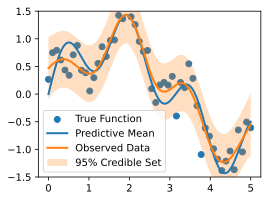

In [13]:
with torch.no_grad():
    # Initialize plot
    f, ax = d2l.plt.subplots(1, 1, figsize=(4, 3))
    # Get upper and lower bounds for 95\% credible set (in this case, in
    # observation space)
    lower, upper = observed_pred.confidence_region()
    ax.scatter(train_x.numpy(), train_y.numpy())
    ax.plot(test_x.numpy(), test_y.numpy(), linewidth=2.0)
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), linewidth=2.0)
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.25)
    ax.set_ylim([-1.5, 1.5])
    ax.legend(["True Function", "Predictive Mean", "Observed Data", "95% Credible Set"])